# Improved Naïve Bayes classifier with BOW and n-gram

In [29]:
import pickle

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from config import N_GRAM
from helper import train_validation_test_data

In [2]:
x_train, x_validation, x_test, y_train, y_validation, y_test = train_validation_test_data()

## Transform corpus to BOW representation (with n-gram and trained token removal)

* Instead of removing standard stopwords and non-alpha tokens, we filter the corpus using our own set of informative words `CUTOFF_LO <= freq(tok) < CUTOFF_HI` from [data_exploration.ipynb](./data_exploration.ipynb). This increase the AUC score of the model by 0.02 while nearly halving the dictionary vector size.

* Add bi-grams features to the BOW vectors, we also remove rare bi-grams to improve performance.

Note:
* I tried using tri-grams, while it made signaficant improvement to the training score, it didn't really improve the validation score. My hypothesis is that the training tri-grams are too specialized which causes the model to overfit.

In [20]:
with open('informative_tokens.pickle', 'rb') as f, open('informative_ngrams.pickle', 'rb') as f_ngram:
    retain = pickle.load(f)
    retain_ngram = pickle.load(f_ngram)

def tokenize(text):
    doc = nlp(text)
    tokens = [token for word in doc if (token := word.lemma_.lower()) in retain]

    ngtoks = [token.lemma_.lower() for token in doc if token.is_alpha]
    if len(ngtoks) > N_GRAM:
        for i in range(0, len(ngtoks) - N_GRAM + 1):
            ngram = ' '.join(ngtoks[i:i+N_GRAM])
            if ngram in retain_ngram:
                tokens.append(ngram)
                
    return tokens

vectorizer = CountVectorizer(tokenizer=tokenize)

In [21]:
train_bow = vectorizer.fit_transform(x_train)
train_bow

<5000x15633 sparse matrix of type '<class 'numpy.int64'>'
	with 223454 stored elements in Compressed Sparse Row format>

In [22]:
classifier = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
classifier.fit(train_bow, y_train)

OneVsRestClassifier(estimator=MultinomialNB(), n_jobs=-1)

## Validation

In [23]:
y_train_pred = classifier.predict_proba(train_bow)

validation_bow = vectorizer.transform(x_validation)
y_validation_pred = classifier.predict_proba(validation_bow)

In [24]:
print('Train ROC AUC:', roc_auc_score(y_train, y_train_pred))
print('Validation ROC AUC:', roc_auc_score(y_validation, y_validation_pred))

Train ROC AUC: 0.9591127148493229
Validation ROC AUC: 0.8159482659026599


## Model evaluation on test set

In [25]:
test_bow = vectorizer.transform(x_test)
y_test_pred = classifier.predict_proba(test_bow)

In [26]:
print('Test ROC AUC:', roc_auc_score(y_test, y_test_pred))

Test ROC AUC: 0.7996726231505727


The test score is improved slightly over the previous simple model, but not significantly.

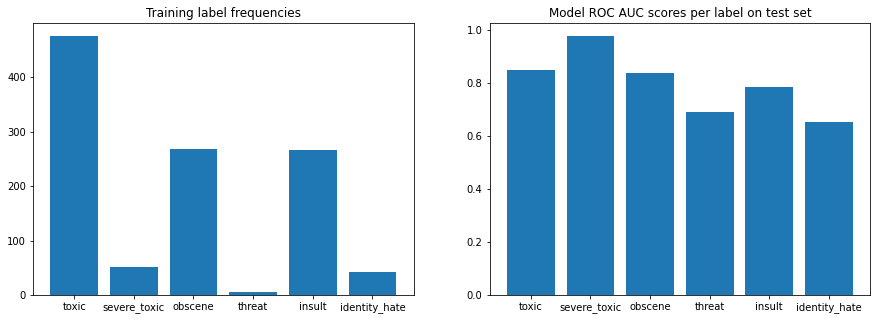

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].bar(range(y_train.shape[1]), y_train.sum(), tick_label=y_train.columns)
axes[0].title.set_text('Training label frequencies')
scores = roc_auc_score(y_test, y_test_pred, average=None)
axes[1].bar(range(y_test.shape[1]), scores, tick_label=y_test.columns)
axes[1].title.set_text('Model ROC AUC scores per label on test set')

Interestingly the unbalanced dataset w.r.t. the number of training instances per label does not affect the test score too severely.